<a href="https://colab.research.google.com/github/esmael-uta/FrontierTechMLBootcamp2025/blob/main/Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import shutil
import time
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Suppress TensorFlow warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

Mounted at /content/drive


In [ ]:
def print_in_color(txt_msg, fore_tuple=(0, 255, 0), back_tuple=(55, 65, 80)):
    rf, gf, bf = fore_tuple
    rb, gb, bb = back_tuple
    msg = f'\33[38;2;{rf};{gf};{bf};48;2;{rb};{gb};{bb}m{txt_msg}\33[0m'
    print(msg, flush=True)

def show_image_samples(gen):
    classes = list(gen.class_indices.keys())
    images, labels = next(gen)
    plt.figure(figsize=(12, 12))
    for i in range(min(9, len(labels))):
        plt.subplot(3, 3, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        plt.title(classes[np.argmax(labels[i])], color='blue')
        plt.axis('off')
    plt.show()

def tr_plot(tr_data, start_epoch):
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    epochs = range(start_epoch, start_epoch + len(tacc))
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tloss, 'r', label='Training Loss')
    plt.plot(epochs, vloss, 'g', label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tacc, 'r', label='Training Accuracy')
    plt.plot(epochs, vacc, 'g', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

def saver(save_path, model, model_name, subject, accuracy, img_size, scalar, generator):
    save_id = f"{model_name}-{subject}-{accuracy:.2f}.h5"
    model_save_loc = os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print_in_color(f"Model saved as {model_save_loc}")

    class_df = pd.DataFrame({
        'class_index': list(generator.class_indices.values()),
        'class': list(generator.class_indices.keys()),
        'height': [img_size[0]] * len(generator.class_indices),
        'width': [img_size[1]] * len(generator.class_indices),
        'scale_by': [scalar] * len(generator.class_indices)
    })
    csv_save_loc = os.path.join(save_path, 'class_dict.csv')
    class_df.to_csv(csv_save_loc, index=False)
    print_in_color(f"Class CSV saved as {csv_save_loc}")
    return model_save_loc, csv_save_loc

In [ ]:
class LRA(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, dwell, batches, initial_epoch, epochs, ask_epoch):
        super(LRA, self).__init__()
        self._model = model
        self._base_model = base_model
        self.patience = patience
        self.stop_patience = stop_patience
        self.threshold = threshold
        self.factor = factor
        self.dwell = dwell
        self.batches = batches
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch

        self.count = 0
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = float(self._model.optimizer.learning_rate.numpy())
        self.highest_tracc = 0.0
        self.lowest_vloss = float('inf')
        self.best_weights = self._model.get_weights()

    def on_train_begin(self, logs=None):
        msg = f"Starting training with base_model {'trainable' if self._base_model.trainable else 'not trainable'}"
        print_in_color(msg, (244, 252, 3))
        print_in_color("Epoch  Loss    Accuracy  V_loss  V_acc   LR      Next LR  Monitor    % Improv  Duration", (244, 252, 3))
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - (getattr(self, 'now', time.time()) if hasattr(self, 'now') else self.start_time)
        self.now = time.time()
        lr = float(self._model.optimizer.learning_rate.numpy())
        v_loss = logs.get('val_loss')
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')

        if acc < self.threshold:
            monitor = 'accuracy'
            pimprov = (acc - self.highest_tracc) * 100 / self.highest_tracc if epoch > 0 else 0
            if acc > self.highest_tracc:
                self.highest_tracc = acc
                self.best_weights = self._model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1
                color = (0, 255, 0)
            else:
                if self.count >= self.patience - 1:
                    color = (245, 170, 66)
                    lr *= self.factor
                    self._model.optimizer.learning_rate.assign(lr)
                    self.count = 0
                    self.stop_count += 1
                    if self.dwell:
                        self._model.set_weights(self.best_weights)
                else:
                    self.count += 1
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
        else:
            monitor = 'val_loss'
            pimprov = (self.lowest_vloss - v_loss) * 100 / self.lowest_vloss if epoch > 0 else 0
            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss
                self.best_weights = self._model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1
                color = (0, 255, 0)
            else:
                if self.count >= self.patience - 1:
                    color = (245, 170, 66)
                    lr *= self.factor
                    self._model.optimizer.learning_rate.assign(lr)
                    self.count = 0
                    self.stop_count += 1
                    if self.dwell:
                        self._model.set_weights(self.best_weights)
                else:
                    self.count += 1
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f"{epoch+1:3d}/{self.epochs:3d} {loss:.3f} {acc*100:.2f} {v_loss:.5f} {v_acc*100:.2f} {lr:.5f} {lr:.5f} {monitor:11s} {pimprov:6.2f} {duration:.1f}"
        print_in_color(msg, color)

        if self.stop_count > self.stop_patience - 1:
            print_in_color(f"Training halted at epoch {epoch+1} after {self.stop_patience} adjustments", (0, 255, 255))
            self._model.stop_training = True
        elif epoch + 1 == self.ask_epoch:
            print_in_color("Enter H to halt, F to fine-tune, or an integer for more epochs:", (0, 255, 255))
            ans = input()
            if ans.lower() == 'h':
                print_in_color(f"Training halted at epoch {epoch+1}", (0, 255, 255))
                self._model.stop_training = True
            elif ans.lower() == 'f':
                self._base_model.trainable = True
                print_in_color("Base model set to trainable for fine-tuning", (0, 255, 255))
                self.ask_epoch += self.ask_epoch_initial
            elif ans.isdigit():
                self.ask_epoch += int(ans)
                print_in_color(f"Training continues until epoch {self.ask_epoch}", (0, 255, 255))

    def on_train_end(self, logs=None):
        duration = time.time() - self.start_time
        hours, rem = divmod(duration, 3600)
        minutes, seconds = divmod(rem, 60)
        self._model.set_weights(self.best_weights)
        print_in_color(f"Training completed at epoch {self.best_epoch}. Time: {int(hours)}h {int(minutes)}m {seconds:.1f}s", (0, 255, 0))

Train: 366, Valid: 20, Test: 21
Found 87 validated image filenames.
Found 92 validated image filenames.
Class counts after augmentation: [187, 150, 150]
Found 487 validated image filenames belonging to 3 classes.
Found 20 validated image filenames belonging to 3 classes.
Found 21 validated image filenames belonging to 3 classes.


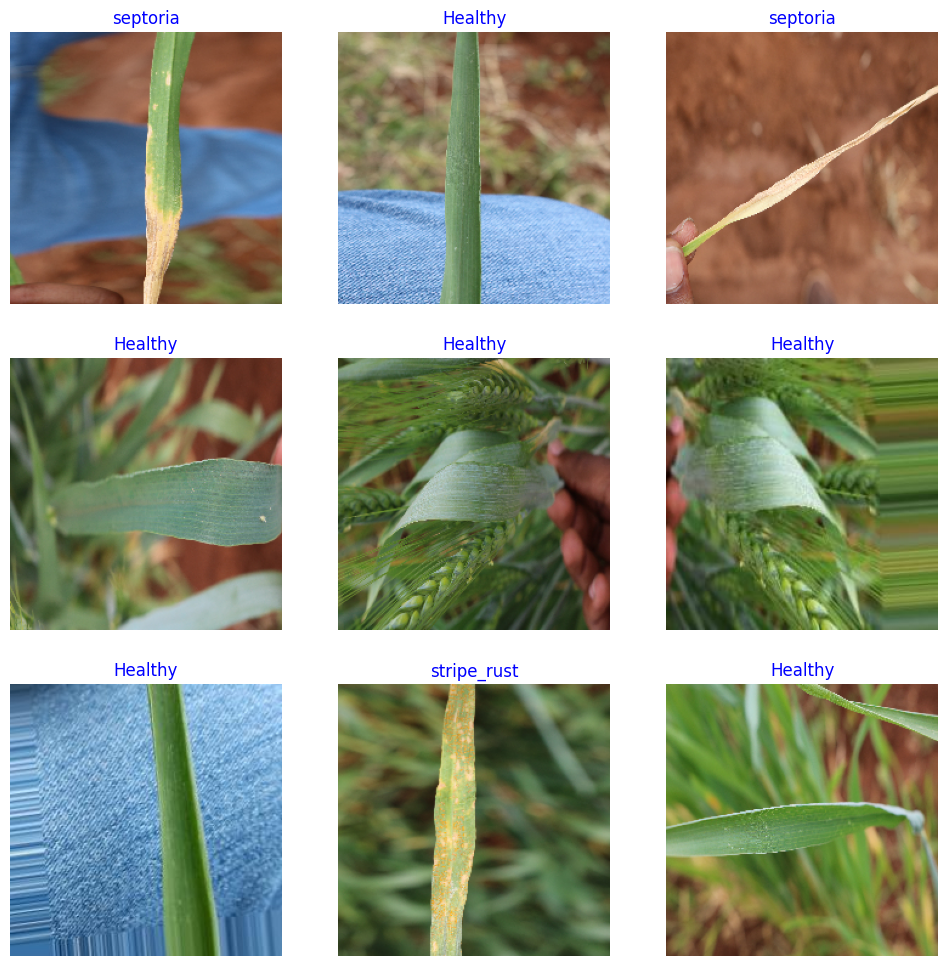

In [ ]:
sdir = "/content/drive/My Drive/wheat_leaf"  # Verify this path
working_dir = "./"
aug_dir = os.path.join(working_dir, 'aug')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.makedirs(aug_dir)

filepaths, labels = [], []
for klass in os.listdir(sdir):
    classpath = os.path.join(sdir, klass)
    for f in os.listdir(classpath):
        filepaths.append(os.path.join(classpath, f))
        labels.append(klass)
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

trsplit, vsplit = 0.9, 0.05
dsplit = vsplit / (1 - trsplit)
train_df, dummy_df = train_test_split(df, train_size=trsplit, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print(f"Train: {len(train_df)}, Valid: {len(valid_df)}, Test: {len(test_df)}")

# Reduce augmentation target and batch size
target = 150  # Lowered from 200 to reduce memory
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, zoom_range=0.2)
for label in train_df['labels'].unique():
    os.makedirs(os.path.join(aug_dir, label), exist_ok=True)
groups = train_df.groupby('labels')
for label in train_df['labels'].unique():
    group = groups.get_group(label)
    if len(group) < target:
        delta = target - len(group)
        aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=(224, 224),  # Reduced from 300x300
                                          class_mode=None, batch_size=1, shuffle=False, save_to_dir=os.path.join(aug_dir, label),
                                          save_prefix='aug-', save_format='jpg')
        for _ in range(delta):
            next(aug_gen)

aug_fpaths, aug_labels = [], []
for klass in os.listdir(aug_dir):
    for f in os.listdir(os.path.join(aug_dir, klass)):
        aug_fpaths.append(os.path.join(aug_dir, klass, f))
        aug_labels.append(klass)
aug_df = pd.DataFrame({'filepaths': aug_fpaths, 'labels': aug_labels})
ndf = pd.concat([train_df, aug_df]).reset_index(drop=True)
print("Class counts after augmentation:", ndf['labels'].value_counts().tolist())

# Use smaller image size and batch size
img_shape = (224, 224, 3)  # Reduced from 300x300
img_size = (224, 224)
batch_size = 16  # Reduced from 30
def scalar(img):
    return img

train_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True).flow_from_dataframe(
    ndf, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
valid_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=True)
test_gen = ImageDataGenerator(preprocessing_function=scalar).flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

train_steps = int(np.ceil(len(train_gen.labels) / batch_size))
test_steps = int(np.ceil(len(test_gen.labels) / batch_size))

show_image_samples(train_gen)

In [ ]:
# Enable GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

model_name = 'EfficientNetB3'
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 40
patience = 1
stop_patience = 3
threshold = 0.9
factor = 0.5
dwell = True
ask_epoch = 10
batches = train_steps

callbacks = [LRA(
    model=model,
    base_model=base_model,
    patience=patience,
    stop_patience=stop_patience,
    threshold=threshold,
    factor=factor,
    dwell=dwell,
    batches=batches,
    initial_epoch=0,
    epochs=epochs,
    ask_epoch=ask_epoch
)]

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    x=train_gen,
    epochs=epochs,
    verbose=0,
    callbacks=callbacks,
    validation_data=valid_gen,
    shuffle=False,
    initial_epoch=0
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Starting training with base_model trainable
Epoch  Loss    Accuracy  V_loss  V_acc   LR      Next LR  Monitor    % Improv  Duration
  1/ 40 16.861 64.89 14.67765 80.00 0.00100 0.00100 accuracy      0.00 430.7
  2/ 40 9.417 63.24 12.85577 35.00 0.00050 0.00050 accuracy     -2.53 299.8
  3/ 40 9.771 72.28 10.60208 70.00 0.00050 0.00050 accuracy     11.39 312.2
  4/ 40 8.343 68.99 10.35143 35.00 0.00025 0.00025 accuracy     -4.55 302.6
  5/ 40 8.440 69.61 9.63435 65.00 0.00013 0.00013 accuracy     -3.69 308.7
  6/ 40 8.679 74.13 9.78198 65.00 0.00013 0.00013 accuracy      2.56 299.2
  7/ 40 8.210 71.87 9.16320 70.00 0.00006 0.00006 accuracy     -3.05 307.8
  8/ 40 8.244 75.56 9.05793 65.00 0.00006 0.00006 accuracy      1.94 299.4
  9/ 40 8.283 71.05 9.03852 65.00 0.00003 0.00003 accuracy     -5.98 307.5
 10/ 40 8.181 75.36 8.64274 65.00 0.00002 0.00002 accuracy     -0.27 317.4
Enter H to halt, F to fine-tune, or an integer for more epochs:
h
Training halted at epoch 10
Training completed 

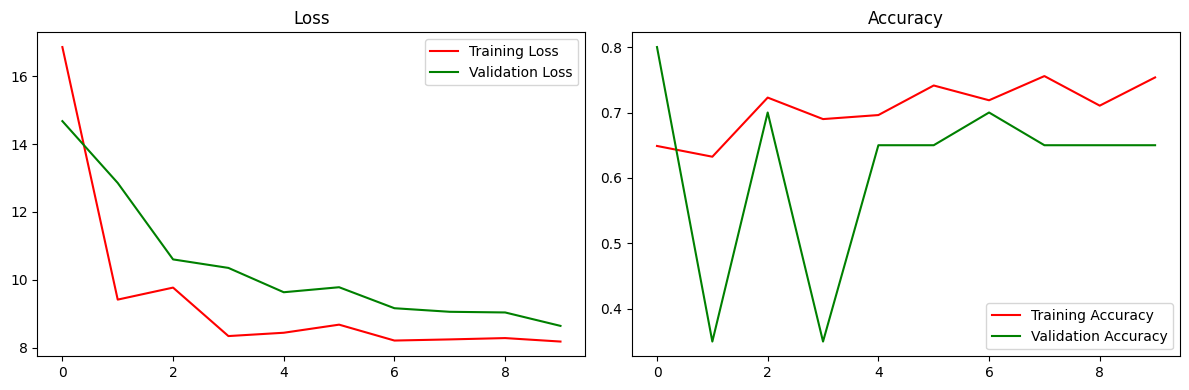

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 489ms/step - accuracy: 0.7262 - loss: 9.0300
Test Accuracy: 71.43%


In [ ]:
tr_plot(history, 0)
test_loss, test_acc = model.evaluate(test_gen, steps=test_steps, verbose=1)
print_in_color(f"Test Accuracy: {test_acc*100:.2f}%", (0, 255, 0))

In [ ]:
save_dir = "/content/drive/My Drive/models1"
os.makedirs(save_dir, exist_ok=True)
model_save_loc, csv_save_loc = saver(save_dir, model, model_name, 'wheat_disease', test_acc*100, img_size, scalar, train_gen)

Model saved as /content/drive/My Drive/models1/EfficientNetB3-wheat_disease-71.43.h5
Class CSV saved as /content/drive/My Drive/models1/class_dict.csv
